In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

In [5]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import contractions_dict as CONTRACTION_MAP
import unicodedata
import warnings
warnings.filterwarnings('ignore')
nlp = spacy.load('en', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
#stopword_list.append('til')
stopword_list.remove('no')
stopword_list.remove('not')

#### Load out train & test dataset. We will do our modeling using just the 1500 train data points using train/test split. The additional 1500 test data points will be used to measure the performance of the model 

In [6]:
df = pd.read_csv("train.csv")
tdf =pd.read_csv("test.csv")
X_ext_test = tdf['title'] # External test set
y_ext_test = tdf['subreddit'] 
X = df['title']
y = df['subreddit']

The following function performas processing on the text. It performs the following on our text:
1. Strip HTML
2. Remove Accented Characters
3. Expand contractions
4. Lowercases the text
5. Remove extra newlines
6. Lematize the text
7. Removes special characters & digits
8. Removes stopwords


In [7]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=False,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
        
        nlp = spacy.load('en', parse=True, tag=True, entity=True)
        #nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
        tokenizer = ToktokTokenizer()
        stopword_list = nltk.corpus.stopwords.words('english')
        #stopword_list.append('til')
        #stopword_list.append('today')
        #stopword_list.append('learned')
        stopword_list.remove('no')
        stopword_list.remove('not')
        
    
        normalized_corpus = []
        # normalize each document in the corpus
        for doc in corpus:
            # strip HTML
            if html_stripping:
                doc = strip_html_tags(doc)
            # remove accented characters
            if accented_char_removal:
                doc = remove_accented_chars(doc)
            # expand contractions    
            if contraction_expansion:
                doc = expand_contractions(doc)
            # lowercase the text    
            if text_lower_case:
                doc = doc.lower()
            # remove extra newlines
            doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
            # lemmatize text
            if text_lemmatization:
                doc = lemmatize_text(doc)
            # remove special characters and\or digits    
            if special_char_removal:
                # insert spaces between special characters to isolate them    
                special_char_pattern = re.compile(r'([{.(-)!}])')
                doc = special_char_pattern.sub(" \\1 ", doc)
                doc = remove_special_characters(doc, remove_digits=remove_digits)  
            # remove extra whitespace
            doc = re.sub(' +', ' ', doc)
            # remove stopwords
            if stopword_removal:
                doc = remove_stopwords(doc, is_lower_case=text_lower_case)

            normalized_corpus.append(doc)

        return normalized_corpus

def strip_html_tags(text):
        soup = BeautifulSoup(text, "html.parser")
        stripped_text = soup.get_text()
        return stripped_text

def remove_accented_chars(text):
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return text

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

Next we will create an object that we can use to perform a modeling. This class will take in the processed data and prepare it for the modeling. It will have methods that allow us to pass in any model we choose to it and will store the results of that model in a dataframe within the class. We can also perform GridSearchCV within the class. The objective of creating this class is to make it more efficient to run various models and compare their results

In [8]:
class words:
    
    '''
    This class must be instantiated with the following inputs:
    X - Training X data, text should already be processed, CountVectors will be created upon instantiation
    y - Traning target data
    X_ext_test - Test X data from our 2nd dataset. Data should be processed
    y - Test target data from our 2nd dataset.
    
    Models can be created using the class's model method. The model saved by the class will be the model that has
    received the highest test score up to then 
    
    Gridsearch can be done using the grid_search method
    
    DataFrame of results can be retrived by calling mods_fitted. Scores used will be:
    1. test score from test data in train-test-split
    2. test score from around 3000 unseen posts from the 2 subreddits
    3. An average of these 2 scores
    '''
    
    def __init__(self,X,y,X_ext_test,y_ext_test,vec = "cv",test_size=0.2,max_df=0.3):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        if vec == "cv":
            self.cv = CountVectorizer(max_df=max_df).fit(self.X_train)
        elif vec == "tfid":
            self.cv = TfidfVectorizer(max_df=max_df,ngram_range=(1, 3),max_features=15000).fit(self.X_train)
        self.X_train = self.cv.transform(self.X_train)
        self.X_test = self.cv.transform(self.X_test)
        self.mods_fitted = pd.DataFrame(columns=['model_name',"params","split_test_score","ext_test_score","mean_score",'model'])
        self.X_ext_test = X_ext_test
        self.y_ext_test = y_ext_test
        self.mod_benchmark = 0
        self.X_ext_test = self.cv.transform(self.X_ext_test)
        
    def model(self,model):
        mod = model.fit(self.X_train,self.y_train)
        test_score = mod.score(self.X_test,self.y_test)
        if test_score>self.mod_benchmark:
            self.mod = mod
            self.mod_benchmark = test_score
        ext_ts = mod.score(self.X_ext_test,self.y_ext_test)
        ms = (test_score+ext_ts)/2
        l = [type(mod).__name__,mod.get_params(),test_score,ext_ts,ms,mod]
        self.mods_fitted.loc[len(self.mods_fitted)] = l
        self.mods_fitted.sort_values("split_test_score",ascending=False,inplace=True)
        
    def grid_search(self,model,params):
        gs = GridSearchCV(model,params,n_jobs=-1,verbose=False)
        gs = gs.fit(self.X_train,self.y_train)
        
        self.gs = gs
        test_score = self.gs.score(self.X_test,self.y_test)
        ext_ts = self.gs.score(self.X_ext_test,self.y_ext_test)
        best_mod = self.gs.best_estimator_
        self.model(best_mod)
       

In [9]:
# Process our train & test data 
X = normalize_corpus(X,contraction_expansion=False) 
X_ext_test = normalize_corpus(tdf['title'],contraction_expansion=False)


Let's see the effec of the word processing on some of the posts

In [10]:
df.loc[4,'title']

'\'We Don\'t Know a Planet Like This\': CO2 Levels Hit 415 PPM for 1st Time in 3 Million+ Yrs - "How is this not breaking news on all channels all over the world?"'

In [11]:
X[4]

'not know planet like co level hit ppm st time million yrs not break news channel world'

In [12]:
df.loc[10,'title']

'Facebook has lost $100 billion in 10 days — and now advertisers are pulling out'

In [560]:
X[10]

'facebook lose billion day advertiser pull'

In [561]:
df.loc[2868,'title']

'TIL about The Hole, an run-down New York City neighborhood that sits 30 feet below grade level and is disconnected from the sewer system.'

In [562]:
X[2868]

'til hole run new york city neighborhood sit foot grade level disconnect sewer system'

#### The word TIL (Today i Learned) appears in nearly all posts on the today i learned subreddit, we will deal with this by setting a max frequency when fitting the Vectorizer

In [13]:
w = words(X,y,X_ext_test,y_ext_test) #Instantiate our class

##### Lets have a look at the vectorized data of word counts to get an idea of the most frequent words from each subreddit

In [14]:
words_df = pd.DataFrame(w.X_train.todense(),columns=w.cv.get_feature_names())

In [565]:
words_df['subreddit'] = w.y_train

In [566]:
wn = pd.DataFrame(words_df.groupby('subreddit').sum().transpose()[1]).sort_values(1,ascending=False)
til = pd.DataFrame(words_df.groupby('subreddit').sum().transpose()[0]).sort_values(0,ascending=False)
wn = wn.rename({1:"world news"},axis=1)
til = til.rename({0:"today i learned"},axis=1)

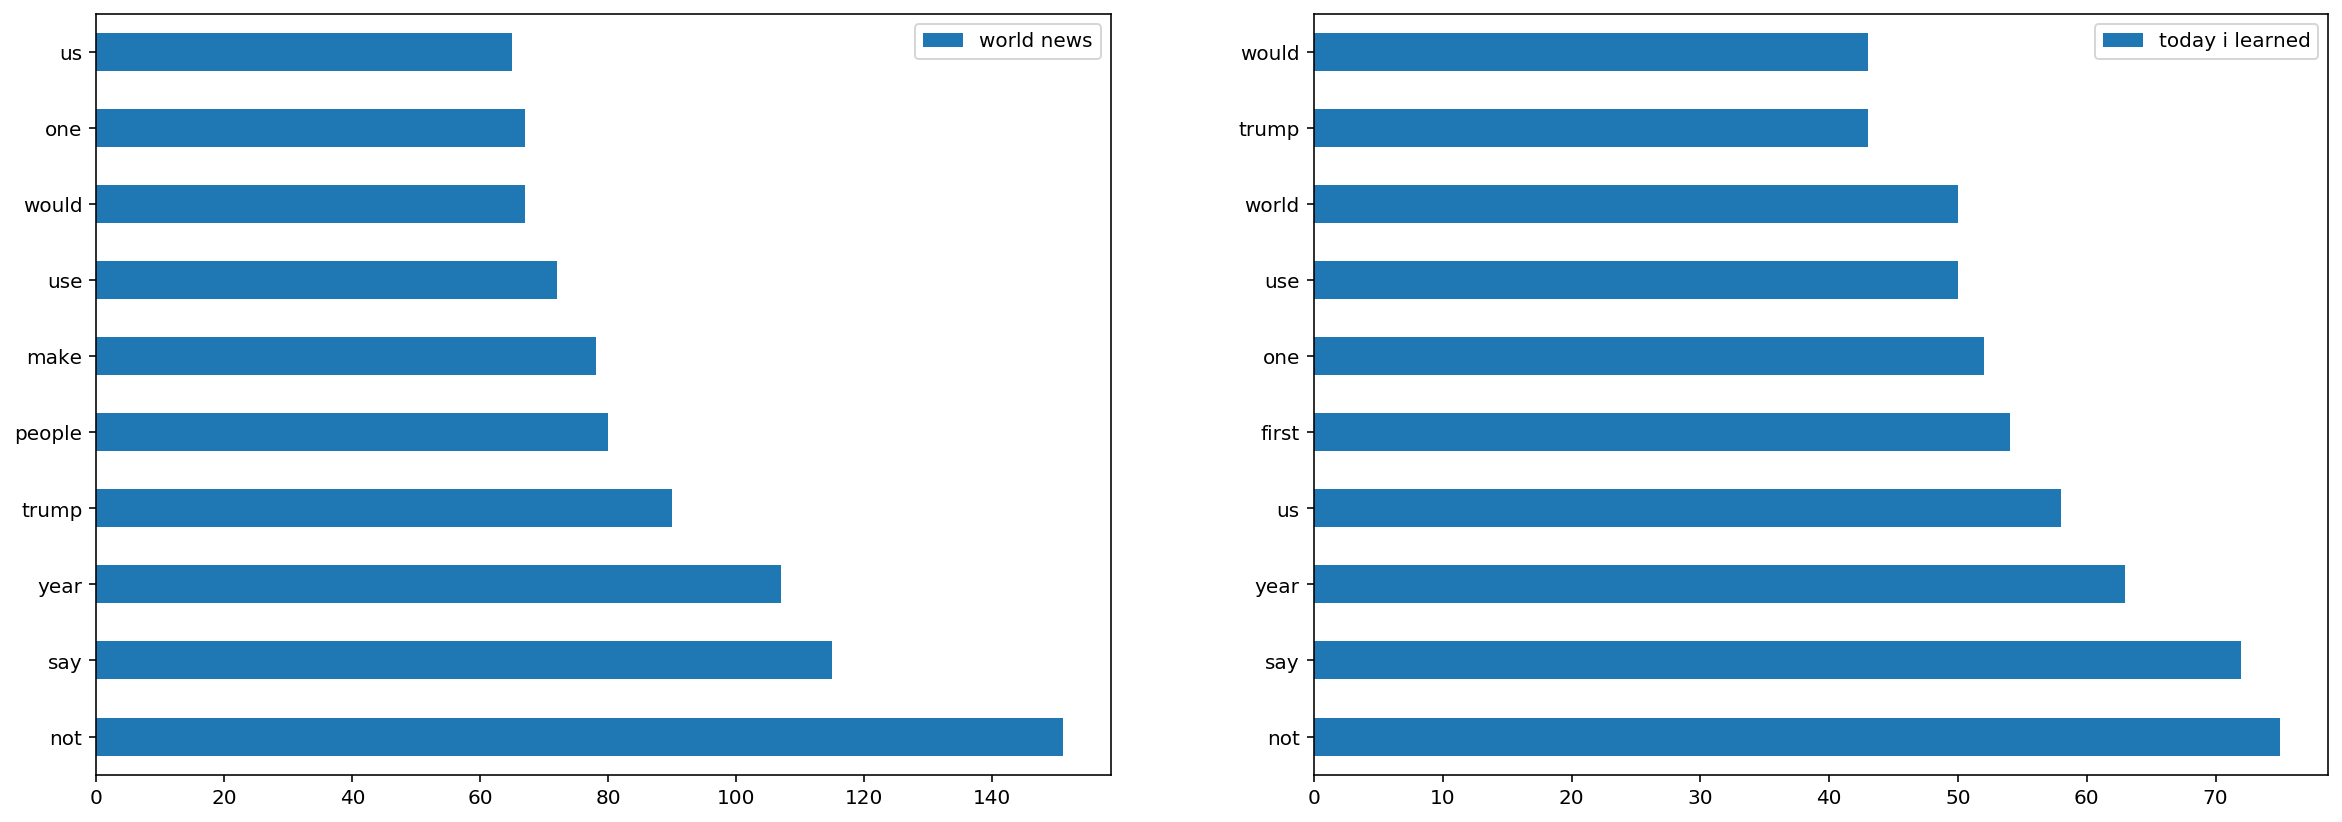

In [567]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20, 7))
wn[0:10].plot.barh(ax=axes[0])
til[0:10].plot.barh(ax=axes[1])

The 3 most frequent words are the same and 7 of the top 10 are the same. 

### First we will create some Naiive Bayes models as our baseline

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
mods = [MultinomialNB(),BernoulliNB()]
for mod in mods:
    w.model(mod)

In [16]:
w.mods_fitted

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.861252,0.895580,0.878416,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.818951,0.845806,0.832378,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."


### Now we will import and create a bunch of other basic models to test using our object

In [17]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
mods = [RandomForestClassifier(random_state=14),ExtraTreesClassifier(random_state=14),DecisionTreeClassifier(random_state=14),LogisticRegression(),
        KNeighborsClassifier()]
for mod in mods:
    w.model(mod)

In [18]:
w.mods_fitted # Check our results so far

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.861252,0.895580,0.878416,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.832487,0.873651,0.853069,"LogisticRegression(C=1.0, class_weight=None, d..."
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.818951,0.845806,0.832378,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
3,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.786802,0.823877,0.805340,"(ExtraTreeClassifier(class_weight=None, criter..."
2,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.769882,0.800209,0.785045,"(DecisionTreeClassifier(class_weight=None, cri..."
4,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.737733,0.766098,0.751915,"DecisionTreeClassifier(class_weight=None, crit..."
6,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.529611,0.539854,0.534732,"KNeighborsClassifier(algorithm='auto', leaf_si..."


### Logistic Regression is currently our best performing model. We will do gridsearch to optimize hyperparameters for RandomForest, ExtraTrees & DecisionTree models

In [19]:
rf_params = {"n_estimators":[75,100,200],
            "max_depth":[50,100,150,200],
            "min_samples_split":[15,10,5],
            "min_samples_leaf":[1],
            }
w.grid_search(RandomForestClassifier(random_state=14),params=rf_params)
w.gs.best_params_

{'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

### Based on the above params we will refine our input params to see if we can get a better score

In [21]:
rf_params = {"n_estimators":[150,100,125],
            "max_depth":[200,25,125],
            "min_samples_split":[5,2,3],
            
            }
w.grid_search(RandomForestClassifier(random_state=14),params=rf_params)
w.gs.best_params_

{'max_depth': 25, 'min_samples_split': 3, 'n_estimators': 100}

In [22]:
w.mods_fitted

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.861252,0.895580,0.878416,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.832487,0.873651,0.853069,"LogisticRegression(C=1.0, class_weight=None, d..."
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.818951,0.845806,0.832378,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
7,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.813875,0.855204,0.834539,"(DecisionTreeClassifier(class_weight=None, cri..."
8,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.808799,0.842325,0.825562,"(DecisionTreeClassifier(class_weight=None, cri..."
3,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.786802,0.823877,0.805340,"(ExtraTreeClassifier(class_weight=None, criter..."
2,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.769882,0.800209,0.785045,"(DecisionTreeClassifier(class_weight=None, cri..."
4,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.737733,0.766098,0.751915,"DecisionTreeClassifier(class_weight=None, crit..."
6,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.529611,0.539854,0.534732,"KNeighborsClassifier(algorithm='auto', leaf_si..."


### Gridsearch for ExtraTrees

In [25]:
et_params = {'n_estimators':[100,150],
            'max_depth':[75,100,150,200],
            'min_samples_split':[25,50,2],
            }

w.grid_search(ExtraTreesClassifier(random_state=14),params=et_params)

In [26]:
w.gs.best_params_

{'max_depth': 100, 'min_samples_split': 25, 'n_estimators': 150}

In [27]:
et_params = {'n_estimators':[100,150],
            'max_depth':[75,100,50],
            'min_samples_split':[10,5,2,25],
            }

w.grid_search(ExtraTreesClassifier(random_state=14),params=et_params)

In [28]:
w.mods_fitted

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.861252,0.895580,0.878416,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
9,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.840948,0.854159,0.847553,"(ExtraTreeClassifier(class_weight=None, criter..."
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.832487,0.873651,0.853069,"LogisticRegression(C=1.0, class_weight=None, d..."
10,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.827411,0.853115,0.840263,"(ExtraTreeClassifier(class_weight=None, criter..."
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.818951,0.845806,0.832378,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
7,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.813875,0.855204,0.834539,"(DecisionTreeClassifier(class_weight=None, cri..."
8,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.808799,0.842325,0.825562,"(DecisionTreeClassifier(class_weight=None, cri..."
3,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.786802,0.823877,0.805340,"(ExtraTreeClassifier(class_weight=None, criter..."
2,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.769882,0.800209,0.785045,"(DecisionTreeClassifier(class_weight=None, cri..."
4,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.737733,0.766098,0.751915,"DecisionTreeClassifier(class_weight=None, crit..."


Experiment with bagging a DecisionTree model

In [29]:
from sklearn.ensemble import BaggingClassifier
mod = BaggingClassifier(DecisionTreeClassifier(),n_estimators=100)
w.model(mod)

In [30]:
w.mods_fitted

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.861252,0.895580,0.878416,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
9,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.840948,0.854159,0.847553,"(ExtraTreeClassifier(class_weight=None, criter..."
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.832487,0.873651,0.853069,"LogisticRegression(C=1.0, class_weight=None, d..."
10,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.827411,0.853115,0.840263,"(ExtraTreeClassifier(class_weight=None, criter..."
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.818951,0.845806,0.832378,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
7,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.813875,0.855204,0.834539,"(DecisionTreeClassifier(class_weight=None, cri..."
8,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.808799,0.842325,0.825562,"(DecisionTreeClassifier(class_weight=None, cri..."
3,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.786802,0.823877,0.805340,"(ExtraTreeClassifier(class_weight=None, criter..."
2,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.769882,0.800209,0.785045,"(DecisionTreeClassifier(class_weight=None, cri..."
11,BaggingClassifier,"{'base_estimator__class_weight': None, 'base_e...",0.764805,0.802645,0.783725,"(DecisionTreeClassifier(class_weight=None, cri..."


#### A quick overview of our results so far, on the test data from our train-test-split of the originald dataset, Multinomial Naiive Bayes is faring the best, but on the dataset of 2500 new posts, Logictic Regression & ExtraTrees have the best accuracy. The Split test score does not seem to be a good indicator of the external test score. Let's sort the datafarme by the mean score instead



In [31]:
w.mods_fitted.sort_values("mean_score",ascending=False)

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.861252,0.895580,0.878416,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.832487,0.873651,0.853069,"LogisticRegression(C=1.0, class_weight=None, d..."
9,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.840948,0.854159,0.847553,"(ExtraTreeClassifier(class_weight=None, criter..."
10,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.827411,0.853115,0.840263,"(ExtraTreeClassifier(class_weight=None, criter..."
7,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.813875,0.855204,0.834539,"(DecisionTreeClassifier(class_weight=None, cri..."
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.818951,0.845806,0.832378,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
8,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.808799,0.842325,0.825562,"(DecisionTreeClassifier(class_weight=None, cri..."
3,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.786802,0.823877,0.805340,"(ExtraTreeClassifier(class_weight=None, criter..."
2,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.769882,0.800209,0.785045,"(DecisionTreeClassifier(class_weight=None, cri..."
11,BaggingClassifier,"{'base_estimator__class_weight': None, 'base_e...",0.764805,0.802645,0.783725,"(DecisionTreeClassifier(class_weight=None, cri..."


#### Let's see if boosting some of our models improves Accuracy

In [32]:
from sklearn.ensemble import AdaBoostClassifier

m = w.mods_fitted.loc[9,'model'] # Start with the best ExtraTreesClassifier model we have. Index 9 in the dataframe
ada = AdaBoostClassifier(m)
w.model(ada)


In [33]:
w.mods_fitted.head()

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.861252,0.895580,0.878416,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
9,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.840948,0.854159,0.847553,"(ExtraTreeClassifier(class_weight=None, criter..."
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.832487,0.873651,0.853069,"LogisticRegression(C=1.0, class_weight=None, d..."
10,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.827411,0.853115,0.840263,"(ExtraTreeClassifier(class_weight=None, criter..."
12,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.825719,0.863209,0.844464,"((ExtraTreeClassifier(class_weight=None, crite..."


AdaBoost model did not improve the accuracy of the ExtraTrees model. Let's see if increasing the no. of estimators increases this further

In [34]:
ada = AdaBoostClassifier(m,n_estimators=100)
w.model(ada)

In [35]:
w.mods_fitted.head(10)

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.861252,0.895580,0.878416,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
9,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.840948,0.854159,0.847553,"(ExtraTreeClassifier(class_weight=None, criter..."
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.832487,0.873651,0.853069,"LogisticRegression(C=1.0, class_weight=None, d..."
10,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.827411,0.853115,0.840263,"(ExtraTreeClassifier(class_weight=None, criter..."
12,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.825719,0.863209,0.844464,"((ExtraTreeClassifier(class_weight=None, crite..."
13,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.820643,0.857988,0.839316,"((ExtraTreeClassifier(class_weight=None, crite..."
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.818951,0.845806,0.832378,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
7,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.813875,0.855204,0.834539,"(DecisionTreeClassifier(class_weight=None, cri..."
8,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.808799,0.842325,0.825562,"(DecisionTreeClassifier(class_weight=None, cri..."
3,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.786802,0.823877,0.805340,"(ExtraTreeClassifier(class_weight=None, criter..."


#### Let's try a voting classifier using some of our best scoring models

In [36]:
from sklearn.ensemble import VotingClassifier 
vc_mods = [('nb',w.mods_fitted.loc[0,'model']),
           ('lr',w.mods_fitted.loc[5,'model']),
           ('et',w.mods_fitted.loc[9,'model']),
          ('rf',w.mods_fitted.loc[8,'model']),
          ('ab',w.mods_fitted.loc[13,'model'])]
vs = VotingClassifier(estimators =vc_mods,voting='soft')
w.model(vs)

In [39]:
w.mods_fitted

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.861252,0.895580,0.878416,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
14,VotingClassifier,"{'estimators': [('nb', MultinomialNB(alpha=1.0...",0.854484,0.903585,0.879035,"VotingClassifier(estimators=[('nb',\n ..."
9,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.840948,0.854159,0.847553,"(ExtraTreeClassifier(class_weight=None, criter..."
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.832487,0.873651,0.853069,"LogisticRegression(C=1.0, class_weight=None, d..."
10,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.827411,0.853115,0.840263,"(ExtraTreeClassifier(class_weight=None, criter..."
12,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.825719,0.863209,0.844464,"((ExtraTreeClassifier(class_weight=None, crite..."
13,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.820643,0.857988,0.839316,"((ExtraTreeClassifier(class_weight=None, crite..."
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.818951,0.845806,0.832378,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
7,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.813875,0.855204,0.834539,"(DecisionTreeClassifier(class_weight=None, cri..."
8,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.808799,0.842325,0.825562,"(DecisionTreeClassifier(class_weight=None, cri..."


In [45]:
w.mods_fitted.loc[[14,5,9,7,12,0]].drop('params',axis=1)

,model_name,split_test_score,ext_test_score,mean_score,model
14,VotingClassifier,0.854484,0.903585,0.879035,"VotingClassifier(estimators=[('nb',\n ..."
5,LogisticRegression,0.832487,0.873651,0.853069,"LogisticRegression(C=1.0, class_weight=None, d..."
9,ExtraTreesClassifier,0.840948,0.854159,0.847553,"(ExtraTreeClassifier(class_weight=None, criter..."
7,RandomForestClassifier,0.813875,0.855204,0.834539,"(DecisionTreeClassifier(class_weight=None, cri..."
12,AdaBoostClassifier,0.825719,0.863209,0.844464,"((ExtraTreeClassifier(class_weight=None, crite..."
0,MultinomialNB,0.861252,0.895580,0.878416,"MultinomialNB(alpha=1.0, class_prior=None, fit..."


In [655]:
count_vec_mods = w.mods_fitted.sort_values('mean_score',ascending=False)
count_vec_mods['vectorizer'] = "count"

##### The AdaBoost model with 50 estimators is still our best model. We will now fit some models using the TFID vectorizer instead of the count vectorizer. Ngram Range for this vectorizer is (1,3) & Max_features is 15000

In [656]:
w = words(X,y,X_ext_test,y_ext_test,"tfid")

In [657]:
mods = [MultinomialNB(),BernoulliNB(),RandomForestClassifier(random_state=14),ExtraTreesClassifier(random_state=14),DecisionTreeClassifier(random_state=14),LogisticRegression(),
        KNeighborsClassifier()]
for mod in mods:
    w.model(mod)

In [658]:
w.mods_fitted

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.884941,0.901497,0.893219,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.868020,0.892447,0.880234,"LogisticRegression(C=1.0, class_weight=None, d..."
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.842640,0.857292,0.849966,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
3,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.798646,0.841977,0.820312,"(ExtraTreeClassifier(class_weight=None, criter..."
6,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.798646,0.823877,0.811262,"KNeighborsClassifier(algorithm='auto', leaf_si..."
2,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.786802,0.825270,0.806036,"(DecisionTreeClassifier(class_weight=None, cri..."
4,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.732657,0.757745,0.745201,"DecisionTreeClassifier(class_weight=None, crit..."


##### Scores for the basic models are simillar to the CountVectorizer scores. We will try to imporve some of these models with GridSearch & Boosting. Interestingly, using TFID vectorizer makes KNN classifier a plausible model

In [659]:
et_params = {'n_estimators':[100,150],
            'max_depth':[100,150,200],
            'min_samples_split':[20,2],
            }

w.grid_search(ExtraTreesClassifier(random_state=14),params=et_params)

In [660]:
w.gs.best_params_

{'max_depth': 200, 'min_samples_split': 2, 'n_estimators': 150}

In [661]:
w.mods_fitted

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.884941,0.901497,0.893219,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.868020,0.892447,0.880234,"LogisticRegression(C=1.0, class_weight=None, d..."
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.842640,0.857292,0.849966,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
7,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.839255,0.871911,0.855583,"(ExtraTreeClassifier(class_weight=None, criter..."
3,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.798646,0.841977,0.820312,"(ExtraTreeClassifier(class_weight=None, criter..."
6,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.798646,0.823877,0.811262,"KNeighborsClassifier(algorithm='auto', leaf_si..."
2,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.786802,0.825270,0.806036,"(DecisionTreeClassifier(class_weight=None, cri..."
4,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.732657,0.757745,0.745201,"DecisionTreeClassifier(class_weight=None, crit..."


In [662]:
et_params = {'n_estimators':[200,150,125],
            'max_depth':[200,225,175],
            'min_samples_split':[5,3,2],
            }

w.grid_search(ExtraTreesClassifier(random_state=14),params=et_params)

In [663]:
w.gs.best_params_

{'max_depth': 200, 'min_samples_split': 2, 'n_estimators': 125}

In [664]:
w.mods_fitted

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.884941,0.901497,0.893219,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.868020,0.892447,0.880234,"LogisticRegression(C=1.0, class_weight=None, d..."
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.842640,0.857292,0.849966,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
7,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.839255,0.871911,0.855583,"(ExtraTreeClassifier(class_weight=None, criter..."
8,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.839255,0.871911,0.855583,"(ExtraTreeClassifier(class_weight=None, criter..."
3,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.798646,0.841977,0.820312,"(ExtraTreeClassifier(class_weight=None, criter..."
6,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.798646,0.823877,0.811262,"KNeighborsClassifier(algorithm='auto', leaf_si..."
2,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.786802,0.825270,0.806036,"(DecisionTreeClassifier(class_weight=None, cri..."
4,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.732657,0.757745,0.745201,"DecisionTreeClassifier(class_weight=None, crit..."


###### Try implementing AdaBoost on our best ExtraTrees model

In [665]:
m = w.mods_fitted.loc[7,'model'] # Start with the best ExtraTreesClassifier model we have. Index 9 in the dataframe
ada = AdaBoostClassifier(m)
w.model(ada)


In [666]:
w.mods_fitted

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.884941,0.901497,0.893219,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.868020,0.892447,0.880234,"LogisticRegression(C=1.0, class_weight=None, d..."
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.842640,0.857292,0.849966,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
9,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.840948,0.867038,0.853993,"((ExtraTreeClassifier(class_weight=None, crite..."
7,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.839255,0.871911,0.855583,"(ExtraTreeClassifier(class_weight=None, criter..."
8,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.839255,0.871911,0.855583,"(ExtraTreeClassifier(class_weight=None, criter..."
3,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.798646,0.841977,0.820312,"(ExtraTreeClassifier(class_weight=None, criter..."
6,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.798646,0.823877,0.811262,"KNeighborsClassifier(algorithm='auto', leaf_si..."
2,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.786802,0.825270,0.806036,"(DecisionTreeClassifier(class_weight=None, cri..."
4,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.732657,0.757745,0.745201,"DecisionTreeClassifier(class_weight=None, crit..."


In [667]:

ada = AdaBoostClassifier(m,n_estimators=100) # Try increasing the no. of estimators to 100
w.model(ada)

In [668]:
w.mods_fitted

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.884941,0.901497,0.893219,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.868020,0.892447,0.880234,"LogisticRegression(C=1.0, class_weight=None, d..."
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.842640,0.857292,0.849966,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
9,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.840948,0.867038,0.853993,"((ExtraTreeClassifier(class_weight=None, crite..."
7,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.839255,0.871911,0.855583,"(ExtraTreeClassifier(class_weight=None, criter..."
8,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.839255,0.871911,0.855583,"(ExtraTreeClassifier(class_weight=None, criter..."
10,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.839255,0.872259,0.855757,"((ExtraTreeClassifier(class_weight=None, crite..."
3,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.798646,0.841977,0.820312,"(ExtraTreeClassifier(class_weight=None, criter..."
6,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.798646,0.823877,0.811262,"KNeighborsClassifier(algorithm='auto', leaf_si..."
2,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.786802,0.825270,0.806036,"(DecisionTreeClassifier(class_weight=None, cri..."


#### Try AdaBoost with our RandomForest model

In [669]:
m = w.mods_fitted.loc[2,'model'] 
ada = AdaBoostClassifier(m,n_estimators=100)
w.model(ada)

In [670]:
w.mods_fitted

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.884941,0.901497,0.893219,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.868020,0.892447,0.880234,"LogisticRegression(C=1.0, class_weight=None, d..."
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.842640,0.857292,0.849966,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
9,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.840948,0.867038,0.853993,"((ExtraTreeClassifier(class_weight=None, crite..."
7,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.839255,0.871911,0.855583,"(ExtraTreeClassifier(class_weight=None, criter..."
8,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.839255,0.871911,0.855583,"(ExtraTreeClassifier(class_weight=None, criter..."
10,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.839255,0.872259,0.855757,"((ExtraTreeClassifier(class_weight=None, crite..."
11,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.813875,0.843369,0.828622,"((DecisionTreeClassifier(class_weight=None, cr..."
3,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.798646,0.841977,0.820312,"(ExtraTreeClassifier(class_weight=None, criter..."
6,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.798646,0.823877,0.811262,"KNeighborsClassifier(algorithm='auto', leaf_si..."


#### Lastly we will experiement with a VotingClassifer combining some of the best models

In [671]:
from sklearn.ensemble import VotingClassifier 
vc_mods = [('nb',w.mods_fitted.loc[0,'model']),
           ('lr',w.mods_fitted.loc[5,'model']),
           ('et',w.mods_fitted.loc[7,'model']),
          ('ab',w.mods_fitted.loc[9,'model'])]
vs = VotingClassifier(estimators =vc_mods,voting='soft')
w.model(vs)


In [680]:
w.mods_fitted

,model_name,params,split_test_score,ext_test_score,mean_score,model


In [673]:
tfid_vec_mods = w.mods_fitted

In [681]:
tfid_vec_mods

,model_name,params,split_test_score,ext_test_score,mean_score,model
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.884941,0.901497,0.893219,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.868020,0.892447,0.880234,"LogisticRegression(C=1.0, class_weight=None, d..."
12,VotingClassifier,"{'estimators': [('nb', MultinomialNB(alpha=1.0...",0.857868,0.896276,0.877072,"VotingClassifier(estimators=[('nb',\n ..."
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.842640,0.857292,0.849966,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
9,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.840948,0.867038,0.853993,"((ExtraTreeClassifier(class_weight=None, crite..."
7,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.839255,0.871911,0.855583,"(ExtraTreeClassifier(class_weight=None, criter..."
8,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.839255,0.871911,0.855583,"(ExtraTreeClassifier(class_weight=None, criter..."
10,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.839255,0.872259,0.855757,"((ExtraTreeClassifier(class_weight=None, crite..."
11,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.813875,0.843369,0.828622,"((DecisionTreeClassifier(class_weight=None, cr..."
3,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.798646,0.841977,0.820312,"(ExtraTreeClassifier(class_weight=None, criter..."


In [678]:
count_vec_mods

,model_name,params,split_test_score,ext_test_score,mean_score,model,vectorizer
15,VotingClassifier,"{'estimators': [('nb', MultinomialNB(alpha=1.0...",0.857868,0.903585,0.880727,"VotingClassifier(estimators=[('nb',\n ...",count
0,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.861252,0.895580,0.878416,"MultinomialNB(alpha=1.0, class_prior=None, fit...",count
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.832487,0.873651,0.853069,"LogisticRegression(C=1.0, class_weight=None, d...",count
9,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.840948,0.854159,0.847553,"(ExtraTreeClassifier(class_weight=None, criter...",count
13,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.834179,0.859032,0.846606,"((ExtraTreeClassifier(class_weight=None, crite...",count
14,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__boot...",0.834179,0.858336,0.846258,"((ExtraTreeClassifier(class_weight=None, crite...",count
10,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.827411,0.853115,0.840263,"(ExtraTreeClassifier(class_weight=None, criter...",count
7,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.813875,0.855204,0.834539,"(DecisionTreeClassifier(class_weight=None, cri...",count
1,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.818951,0.845806,0.832378,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",count
8,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.808799,0.842325,0.825562,"(DecisionTreeClassifier(class_weight=None, cri...",count


### We will go with the VotingClassifier model using CountVectorier as this has the highest scores across the different tests. Interestingly, despite being a simple model, the Multinomial naiive bayes is still in contention with the other more complex models. The MultinomialNM models had an accuracy of 89.5% on the unseen data set. Let's have a comparison of these 2 models

In [695]:
final_mod = count_vec_mods.loc[15,'model']
nb_mod = count_vec_mods.loc[0,'model']
w = words(X,y,X_ext_test,y_ext_test)
final_pred = final_mod.predict(w.X_ext_test)
nb_pred = nb_mod.predict(w.X_ext_test)

In [729]:
final_mod.estimators

[('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)),
 ('lr',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False)),
 ('et',
  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=25,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=14, verbose=0,
                       warm_start=False)),
 ('rf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',


In [696]:

results = pd.DataFrame({"post":tdf['title'],"prediction":final_pred,'target':w.y_ext_test})
wrongs = results.loc[results['prediction']!=results['target']]
wrongs = wrongs.reset_index(drop=True)
wrongs['prediction'] = wrongs['prediction'].map({0:"today i learned",1:"world news"})
wrongs['target'] = wrongs['target'].map({0:"today i learned",1:"world news"})

In [711]:
wrongs

,post,prediction,target
0,Microsoft Japan’s experiment with a 3-day week...,today i learned,world news
1,Hong Kong police are spraying protesters with ...,today i learned,world news
2,German locals purchase town's entire beer supp...,today i learned,world news
3,Nobel Peace Prize winner and Yazidi activist N...,today i learned,world news
4,Student in Peru makes history by writing thesi...,today i learned,world news
...,...,...,...
272,TIL that the first Prime Minister of independe...,world news,today i learned
273,TIL Pakistan arrested the doctor who helped th...,world news,today i learned
274,"TIL at the request of the US, South Korea sent...",world news,today i learned
275,TIL that in 1965 South Africa gave Israel 100 ...,world news,today i learned


In [709]:

nb = pd.DataFrame({"post":tdf['title'],"prediction":nb_pred,'target':w.y_ext_test})
nb_wrongs = nb.loc[nb['prediction']!=nb['target']]
nb_wrongs = nb_wrongs.reset_index(drop=True)
nb_wrongs['prediction'] = nb_wrongs['prediction'].map({0:"today i learned",1:"world news"})
nb_wrongs['target'] = nb_wrongs['target'].map({0:"today i learned",1:"world news"})

In [710]:
nb_wrongs

,post,prediction,target
0,Microsoft Japan’s experiment with a 3-day week...,today i learned,world news
1,"Alan Turing, World War Two codebreaker and mat...",today i learned,world news
2,Coca-Cola Named Most Polluting Brand in Global...,today i learned,world news
3,Hong Kong police are spraying protesters with ...,today i learned,world news
4,German locals purchase town's entire beer supp...,today i learned,world news
...,...,...,...
295,TIL that the first Prime Minister of independe...,world news,today i learned
296,TIL Pakistan arrested the doctor who helped th...,world news,today i learned
297,"TIL at the request of the US, South Korea sent...",world news,today i learned
298,TIL that in 1965 South Africa gave Israel 100 ...,world news,today i learned


277 of the 2873 posts are classified wrongly using the Voting Classifier model. That is an accuracy of 90.35%.  Accuracy of the Naive Bayes model 89.5% 

### AOC, ROC Curves

In [46]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
fpr, tpr, threshold = metrics.roc_curve(w.y_ext_test, nb_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC - Naive Bayes')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

NameError: name 'nb_pred' is not defined

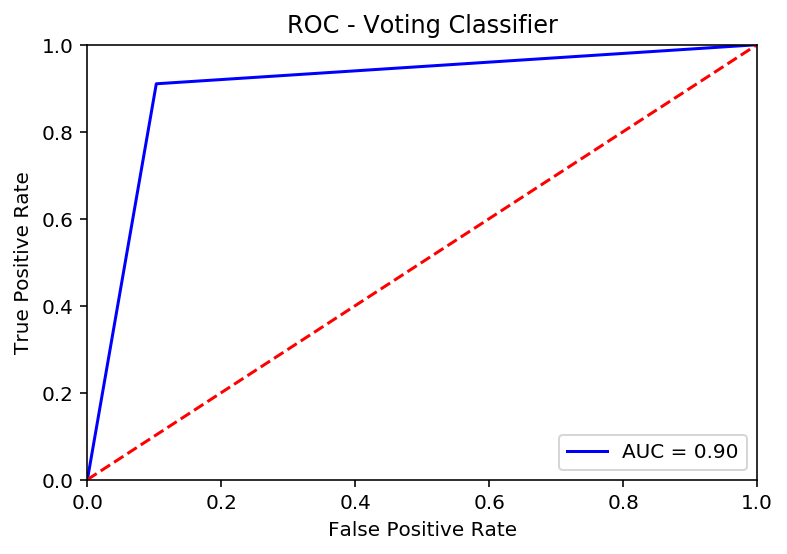

In [715]:
fpr, tpr, threshold = metrics.roc_curve(w.y_ext_test, final_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC - Voting Classifier')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Conclusion

We can conclude that these 2 models work fairly well but there is still scope for improvement. For future models, perhaps we can consider collecting more training data or using more complex models such as SVM's to improve the accuracy.